### Installing SAM2

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /kaggle/working/segment-anything-2
!pip install -q -e .

In [ ]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

### Importing libraries

In [1]:
%cd /ediss_data/ediss4/sarosh/mira/Thesis/segment-anything-2/

/ediss_data/ediss4/sarosh/mira/Thesis/segment-anything-2


In [6]:
import os
import numpy as np
import torch
import shutil
from tqdm import tqdm
import cv2
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from contextlib import nullcontext
from torch.cuda.amp import autocast, GradScaler 

In [3]:
PROJECT_DIR = "/ediss_data/ediss4/sarosh/mira/Thesis"

In [ ]:
train_images_dir = PROJECT_DIR + '/sam_dataset_new/images/train'
train_masks_dir = PROJECT_DIR + '/sam_dataset_new/masks/combined/train'
val_images_dir = PROJECT_DIR + '/sam_dataset_new/images/val'
val_masks_dir = PROJECT_DIR + '/sam_dataset_new/masks/combined/val'

### Setting training parameters

In [5]:
train_data = []
for image in os.listdir(train_images_dir):
    image_name = image
    # replace .png with _combined.png
    mask_name = image.replace(".png", "_combined.png")

    # Append image and corresponding mask paths
    train_data.append({
        "image": os.path.join(train_images_dir, image_name),
        "annotation": os.path.join(train_masks_dir, mask_name)
    })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for image in os.listdir(val_images_dir):
    image_name = image
    mask_name = image.replace(".png", "_combined.png")

    # Append image and corresponding mask paths
    test_data.append({
        "image": os.path.join(val_images_dir, image_name),
        "annotation": os.path.join(val_masks_dir, mask_name)
    })

In [7]:
sam2_checkpoint = "sam2_hiera_base_plus.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_b+.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
num_classes = 2  # excluding background
def read_batch(
    data,
    visualize_data=False,
    max_side=None,
    max_instances_per_image=None
):
    try:
        ent = data[np.random.randint(len(data))]
        img_bgr = cv2.imread(ent["image"], cv2.IMREAD_COLOR)
        if img_bgr is None:
            return None, None, None, None, None
        Img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

        if Img is None or ann_map is None:
            return None, None, None, None, None

        # resize only if max_side is given
        if max_side is not None:
            r = min(max_side / Img.shape[1], max_side / Img.shape[0])
            new_wh = (int(Img.shape[1] * r), int(Img.shape[0] * r))
            Img = cv2.resize(Img, new_wh, interpolation=cv2.INTER_LINEAR)
            ann_map = cv2.resize(ann_map, new_wh, interpolation=cv2.INTER_NEAREST)

        class_vals = [c for c in np.unique(ann_map) if c != 0]  # non-background classes
        inst_masks = []
        points = []
        class_ids = []

        kernel = np.ones((3,3), np.uint8)

        # one positive point per connected component (instance) for each class
        for c in class_vals:
            comp_n, comp = cv2.connectedComponents((ann_map == c).astype(np.uint8))
            for lid in range(1, comp_n):
                inst = (comp == lid).astype(np.uint8)
                if inst.sum() == 0:
                    continue
                eroded = cv2.erode(inst, kernel, iterations=1)
                if eroded.sum() == 0:
                    eroded = inst
                coords = np.argwhere(eroded > 0)
                if len(coords) == 0:
                    continue
                #y, x = coords[np.random.randint(len(coords))]
                ys, xs = np.where(inst > 0)
                x = int(xs.mean()); y = int(ys.mean())
                points.append([x, y])     # x, y
                inst_masks.append(inst)   # HxW
                class_ids.append(c)

        if len(points) == 0:
            return Img, None, None, None, None

        # cap number of instances if desired
        if max_instances_per_image is not None and len(points) > max_instances_per_image:
            idx = np.random.choice(len(points), size=max_instances_per_image, replace=False)
            inst_masks = [inst_masks[i] for i in idx]
            points = [points[i] for i in idx]
            class_ids = [class_ids[i] for i in idx]

        masks = np.stack(inst_masks, axis=0).astype(np.float32)    # (N,H,W)
        point_coords = np.array(points, dtype=np.int32)[:, None, :]  # (N,1,2)
        point_labels = np.ones((len(points), 1), dtype=np.int32)     # positives

        if visualize_data:
            bin_mask = masks.max(axis=0)
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1); plt.title('Original'); plt.imshow(Img); plt.axis('off')
            plt.subplot(1,3,2); plt.title('Binarized Mask'); plt.imshow(bin_mask, cmap='gray'); plt.axis('off')
            plt.subplot(1,3,3); plt.title('Mask + Points'); plt.imshow(bin_mask, cmap='gray')
            colors = list(mcolors.TABLEAU_COLORS.values())
            for i, p in enumerate(point_coords[:,0,:]):
                plt.scatter(p[0], p[1], s=100, c=colors[i % len(colors)])
            plt.axis('off'); plt.tight_layout(); plt.show()
        
        Img = np.ascontiguousarray(Img)                      # HxWx3, uint8
        masks = np.ascontiguousarray(masks.astype(np.float32)) # NxHxW, float32
        point_coords = np.ascontiguousarray(point_coords)      # Nx1x2, int32
        point_labels = np.ascontiguousarray(point_labels)
        return Img, masks, point_coords, point_labels, np.array(class_ids, dtype=np.int32)
    
    except Exception as e:
        print(f"Error in read_batch: {e}")
        return None, None, None, None, None

def validate_model(predictor, val_data, device, num_samples=10):
    model = predictor.model
    model.eval()

    total_iou = 0.0
    total_f1 = 0.0
    total_precision = 0.0
    total_recall = 0.0
    count = 0

    # Per-class accumulators
    class_ious = {c: [] for c in range(1, num_classes + 1)}
    class_f1s = {c: [] for c in range(1, num_classes + 1)}

    with torch.no_grad():
        for _ in range(num_samples):
            image, masks, input_point, input_label, class_ids = read_batch(
                val_data, visualize_data=False
            )
            if image is None or masks is None or input_point is None or input_point.size == 0:
                continue

            masks_tensor = torch.as_tensor(masks, device=device, dtype=torch.float32)

            # Prepare image features
            predictor.set_image(image)

            # Use one positive point per instance
            N_pos = masks.shape[0]
            if input_point.shape[0] < N_pos:
                continue

            pos_points = input_point[:N_pos]
            pos_labels = np.ones((N_pos, 1), dtype=np.int32)

            # IMPORTANT: normalize coords same as in training
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                pos_points, pos_labels, box=None, mask_logits=None, normalize_coords=True
            )
            if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0:
                continue

            unnorm_coords_t = torch.as_tensor(unnorm_coords, device=device, dtype=torch.float32)
            labels_t = torch.as_tensor(labels, device=device, dtype=torch.int32)

            # Get BOTH sparse & dense prompt embeddings
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords_t, labels_t), boxes=None, masks=None
            )

            # Decode masks (multimask gives multiple proposals; we’ll take the first)
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),   # (1, C, H', W')
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),             # batch=1 is expected
            sparse_prompt_embeddings=sparse_embeddings,                              # (N_pos, T, C)
            dense_prompt_embeddings=dense_embeddings,                                # (N_pos, C, H', W') or proper token form per impl
            multimask_output=True,
            repeat_image=True,        # <-- IMPORTANT: allows tokens batch > 1 with image batch == 1
            high_res_features=[lvl[-1].unsqueeze(0) for lvl in predictor._features["high_res_feats"]],
            )

            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])  # (N, M, H, W)
            logits = prd_masks[:, 0]               # take mask head 0: (N,H,W)
            gt_mask = masks_tensor[:N_pos]         # (N,H,W)

            pred = (logits > 0).float()

            # Per-instance stats
            TP = (gt_mask * pred).sum((1, 2))
            FP = ((1 - gt_mask) * pred).sum((1, 2))
            FN = (gt_mask * (1 - pred)).sum((1, 2))

            inter = TP
            union = TP + FP + FN + 1e-6
            iou = (inter / union).clamp_min(0.0)

            # Micro-F1 (Dice)
            TPm, FPm, FNm = TP.sum(), FP.sum(), FN.sum()
            precision = TPm / (TPm + FPm + 1e-6)
            recall = TPm / (TPm + FNm + 1e-6)
            f1_micro = (2 * TPm) / (2 * TPm + FPm + FNm + 1e-6)

            total_iou += iou.mean().item()
            total_f1 += f1_micro.item()
            total_precision += precision.item()
            total_recall += recall.item()
            count += 1

            # Per-class IoU & F1
            for i in range(N_pos):
                cid = class_ids[i]            # 1..num_classes
                inter = (gt_mask[i]*pred[i]).sum()
                union = gt_mask[i].sum() + pred[i].sum() - inter + 1e-6
                iou_c = inter / union
                f1_c  = (2*inter) / (gt_mask[i].sum() + pred[i].sum() + 1e-6)
                class_ious[cid].append(iou_c.item())
                class_f1s[cid].append(f1_c.item())

    model.train()
    if count == 0:
        return 0.0, 0.0, 0.0, 0.0, {}
    # Aggregate per-class metrics
    per_class_results = {}
    for cls_id in range(1, num_classes + 1):
        per_class_results[cls_id] = {
            "IoU": np.mean(class_ious[cls_id]) if class_ious[cls_id] else 0.0,
            "F1": np.mean(class_f1s[cls_id]) if class_f1s[cls_id] else 0.0,
        }
    return total_iou / count, total_f1 / count, total_precision / count, total_recall / count, per_class_results

### Training & Validating

In [8]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)
NO_OF_STEPS = 3000 
# Configure optimizer and scheduler
#optimizer = torch.optim.AdamW(params=predictor.model.parameters(), lr=3e-4, weight_decay=1e-4)

def wd_groups(model):
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad: continue
        if n.endswith(".bias") or "norm" in n.lower() or "ln" in n.lower() or "embedding" in n.lower():
            no_decay.append(p)
        else:
            decay.append(p)
    return [
        {"params": decay, "weight_decay": 1e-4},
        {"params": no_decay, "weight_decay": 0.0},
    ]

optimizer = torch.optim.AdamW(wd_groups(predictor.model), lr=1e-4, betas=(0.9, 0.999))

warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=150)
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NO_OF_STEPS)
scheduler = torch.optim.lr_scheduler.ChainedScheduler([warmup, cosine])
use_amp = False  # set False first to debug; turn True after it’s stable
scaler = GradScaler(enabled=use_amp)
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"


/tmp/ipykernel_494820/1544446934.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


In [ ]:
def train_sam2(
    predictor,
    train_data,
    val_data=None,
    NO_OF_STEPS=3000,
    optimizer=None,
    scheduler=None,
    scaler=None,
    accumulation_steps=4,
    fine_tuned_model_name="fine_tuned_sam2",
    device="cuda",
    freeze_image_encoder=True,
    reader_kwargs=None,
    print_every=500,
    validate_every=1000,
    num_val_samples=5
):

    model = predictor.model
    model.train()
    model.to(device)

    # (optional) freeze image encoder for stability/Phase-1 training
    if freeze_image_encoder and hasattr(model, "image_encoder"):
        for p in model.image_encoder.parameters():
            p.requires_grad = False

    # Create cosine annealing scheduler if not provided
    if scheduler is None:
        scheduler = CosineAnnealingLR(optimizer, T_max=NO_OF_STEPS)

    mean_iou = 0.0
    mean_f1 = 0.0
    mean_precision = 0.0
    mean_recall = 0.0
    opt_steps = 0
    best_val_iou = -1.0 
    reader_kwargs = reader_kwargs or {}
    
    # --- HISTORY LOGS --- 
    history = { "step": [], 
               "train_iou": [], 
               "train_f1": [], 
               "val_iou": [], 
               "val_f1": [],
                "total_loss": [],
                "seg_loss": [],
                "score_loss": []}
    # Create directory for saving models
    os.makedirs(os.path.dirname(fine_tuned_model_name) if os.path.dirname(fine_tuned_model_name) else ".", exist_ok=True)

    for step in range(1, NO_OF_STEPS + 1):
        # Unfreeze at step 1001
        if step == 1001:
            for p in model.sam_prompt_encoder.parameters():
                p.requires_grad = True
            print(">> Unfroze prompt encoder at step 1001")
        # Clear gradients at the start of each step
        optimizer.zero_grad()
        
        total_loss = 0.0
        total_seg_loss = 0.0
        total_score_loss = 0.0
        total_iou_batch = 0.0
        total_f1_batch = 0.0
        total_precision_batch = 0.0
        total_recall_batch = 0.0
        batch_count = 0
        # Accumulate gradients
        for _ in range(accumulation_steps):
            #with torch.cuda.amp.autocast():
            ctx = autocast(enabled=use_amp) if use_amp else nullcontext()
            with ctx:
                image, masks, input_point, input_label, _ = read_batch(
                    train_data, visualize_data=False, **reader_kwargs
                )
                if image is None or masks is None or input_point is None or input_point.size == 0:
                    continue

                # Move data to device
                masks_tensor = torch.as_tensor(masks, device=device, dtype=torch.float32)
                input_point_tensor = torch.as_tensor(input_point, device=device, dtype=torch.int32)
                input_label_tensor = torch.as_tensor(input_label, device=device, dtype=torch.int32)

                # image features
                predictor.set_image(image)

                # ---- use only positive prompts (first N_pos rows) ----
                N_pos = masks.shape[0]                     # one GT per instance
                if input_point_tensor.shape[0] < N_pos:           # safety
                    continue

                pos_points = input_point_tensor[:N_pos]           # (N_pos,1,2)
                pos_labels = torch.ones((N_pos,1), dtype=torch.int32, device=device)  # (N_pos,1)

                # prep prompts only with positives, so preds == GT count
                mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                    pos_points.cpu().numpy(), pos_labels.cpu().numpy(), box=None, mask_logits=None, normalize_coords=True
                )
                if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0:
                    continue
                    
                # Convert back to tensors on the correct device
                unnorm_coords = torch.as_tensor(unnorm_coords, device=device, dtype=torch.float32)
                labels = torch.as_tensor(labels, device=device, dtype=torch.int32)

                sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                    points=(unnorm_coords, labels), boxes=None, masks=None
                )

                # With this (consistent with validation):
                high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

                # Process each instance separately to avoid batch size issues
                all_masks = []
                all_scores = []

                for i in range(unnorm_coords.shape[0]):
                    # Get single instance embeddings
                    single_points = unnorm_coords[i:i+1]
                    single_labels = labels[i:i+1]
                    
                    single_sparse, single_dense = predictor.model.sam_prompt_encoder(
                        points=(single_points, single_labels), boxes=None, masks=None
                    )
                    
                    # Use the same approach as validation
                    single_masks, single_scores, _, _ = predictor.model.sam_mask_decoder(
                        image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                        sparse_prompt_embeddings=single_sparse,
                        dense_prompt_embeddings=single_dense,
                        multimask_output=True,
                        repeat_image=True,
                        high_res_features=high_res_features,
                    )
                    
                    all_masks.append(single_masks)
                    all_scores.append(single_scores)

                # Concatenate results
                low_res_masks = torch.cat(all_masks, dim=0)
                prd_scores = torch.cat(all_scores, dim=0)
                prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])  # (N_pos, M, H, W)
                logits = prd_masks[:, 0]                       # (N,H,W) first mask head
                gt_mask = masks_tensor[:N_pos]  # (N_pos, H, W)
                
                gt_mask = gt_mask.clamp(0,1)
                # losses
                bce = F.binary_cross_entropy_with_logits(logits, gt_mask, reduction='none')  # (N,H,W)
                seg_loss = bce.mean(dim=(1,2)).mean()

                pred = (logits > 0).float()
                # Per-instance stats (pixel-wise)
                TP = (gt_mask * pred).sum((1, 2))
                FP = ((1 - gt_mask) * pred).sum((1, 2))
                FN = (gt_mask * (1 - pred)).sum((1, 2))

                # IoU (as before)
                inter = TP
                union = TP + FP + FN + 1e-6
                iou = (inter / union).clamp_min(0.0)

                # Micro-F1 (sum over instances first)
                TPm = TP.sum(); FPm = FP.sum(); FNm = FN.sum()
                precision = TPm / (TPm + FPm + 1e-6)
                recall = TPm / (TPm + FNm + 1e-6)
                f1_micro = (2 * TPm) / (2 * TPm + FPm + FNm + 1e-6)

                probs = torch.sigmoid(logits32)
                smooth = 1e-6
                intersection = (probs * gt32).sum(dim=(1,2))
                dice = (2*intersection + smooth) / (probs.sum(dim=(1,2)) + gt32.sum(dim=(1,2)) + smooth)
                dice_loss = 1 - dice.mean()
                score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
                loss = seg_loss + 0.05*score_loss + 0.5*dice_loss
                #loss = seg_loss + 0.05 * score_loss

                # *** EARLY GUARD ***
                if not torch.isfinite(seg_loss) or not torch.isfinite(score_loss) or not torch.isfinite(loss):
                    print(f"[skip] non-finite loss at step {step} (seg={seg_loss.item():.4g}, score={score_loss.item():.4g})")
                    optimizer.zero_grad(set_to_none=True)
                    continue
                # grad accumulation
                loss = loss / accumulation_steps
                if use_amp:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()
                
                # Track metrics for this batch
                total_loss += loss.item() * accumulation_steps  # Reverse the division
                total_seg_loss += seg_loss.item()
                total_score_loss += score_loss.item()
                total_iou_batch += iou.mean().item()
                total_f1_batch += f1_micro.item()
                total_precision_batch += precision.item()
                total_recall_batch += recall.item()
                batch_count += 1

        # Skip optimization if no batches were processed
        if batch_count == 0:
            continue
            
        # Calculate average metrics
        avg_seg_loss = total_seg_loss / batch_count
        avg_score_loss = total_score_loss / batch_count
        avg_iou = total_iou_batch / batch_count
        avg_f1 = total_f1_batch / batch_count
        avg_precision = total_precision_batch / batch_count
        avg_recall = total_recall_batch / batch_count


        # Check if any gradients exist
        has_gradients = any(p.grad is not None for p in model.parameters())
        if has_gradients:
            # Unscale gradients before clipping
            scaler.unscale_(optimizer)

            for p in model.parameters():
                if p.grad is not None:
                    p.grad.nan_to_num_(0.0, 0.0, 0.0)
                    
            # Apply gradient clipping (clipping norms to max_norm of 1.0)
            grad_norm = torch.nn.utils.clip_grad_norm_(
                [p for p in model.parameters() if p.grad is not None], max_norm=0.5
            )
            if use_amp:
                if torch.isfinite(grad_norm):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                else:
                    print(f"Step {step}: Invalid grad norm ({grad_norm}), skipping step")
                    optimizer.zero_grad(set_to_none=True)
            else:
                if torch.isfinite(grad_norm):
                    optimizer.step()
                else:
                    print(f"Step {step}: Invalid grad norm ({grad_norm}), skipping step")
                optimizer.zero_grad(set_to_none=True)
        else:
            print(f"Step {step}: No gradients found, skipping optimization")
            optimizer.zero_grad(set_to_none=True)

        # **Always** call update(), even if we skipped step()
        scaler.update()
        scheduler.step()
        opt_steps += 1

        # EMA metrics for printout
        if step == 1:
            mean_iou = avg_iou
            mean_f1 = avg_f1
            mean_precision = avg_precision
            mean_recall = avg_recall
        else:
            mean_iou = 0.99 * mean_iou + 0.01 * avg_iou
            mean_f1 = 0.99 * mean_f1 + 0.01 * avg_f1
            mean_precision = 0.99 * mean_precision + 0.01 * avg_precision
            mean_recall = 0.99 * mean_recall + 0.01 * avg_recall

        # --- Append training history --- 
        history["step"].append(step) 
        history["train_iou"].append(mean_iou) 
        history["train_f1"].append(mean_f1)
        history["total_loss"].append(total_loss / batch_count)
        history["seg_loss"].append(avg_seg_loss)
        history["score_loss"].append(avg_score_loss)

        if (step % print_every) == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(
                f"Step {step} | opt-steps {opt_steps} | LR: {current_lr:.6f} | "
                f"IoU(EMA): {mean_iou:.4f} | F1(EMA): {mean_f1:.4f} | "
                f"seg_loss: {avg_seg_loss:.4f} | score_loss: {avg_score_loss:.4f} | "
                f"Precision: {mean_precision:.4f} | Recall: {mean_recall:.4f}"
            )
            
        # Validation
        if val_data is not None and (step % validate_every) == 0:
            val_iou, val_f1, val_precision, val_recall, per_class = validate_model(predictor, val_data, device, num_val_samples)
            print(f"Validation | Step {step} | IoU: {val_iou:.4f} | F1: {val_f1:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")
            for cls_id, metrics in per_class.items():
                print(f"   Class {cls_id} | IoU: {metrics['IoU']:.4f} | F1: {metrics['F1']:.4f}")
            # --- Append validation history ---
            history["val_iou"].append(val_iou)
            history["val_f1"].append(val_f1)
            
            # --- Save best model by validation IoU ---
            if val_iou > best_val_iou:
                best_val_iou = val_iou
                fname = f"{fine_tuned_model_name}_best-check2.pth"
                torch.save(model.state_dict(), fname)
                print(f"New best model saved at step {step} with IoU {val_iou:.4f}")
            
    # Save final model
    fname = f"{fine_tuned_model_name}_final-check2.pth"
    torch.save(model.state_dict(), fname)
    print(f"Final model saved at step {step} as {fname}")
    # Save final history to a JSON file
    with open(f"{fine_tuned_model_name}_training_history.json", "w") as f:
        json.dump(history, f)
        print(f"Training history saved to {fine_tuned_model_name}_training_history.json")

    return history
                

# Train the model
history = train_sam2(
    predictor,
    train_data,
    val_data=test_data,  # Add validation data
    NO_OF_STEPS=NO_OF_STEPS,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    accumulation_steps=8,
    fine_tuned_model_name=FINE_TUNED_MODEL_NAME,
    freeze_image_encoder=True,
    reader_kwargs=dict(max_side=None, max_instances_per_image=64),
    print_every=400,
    validate_every=500,
    num_val_samples=50
)

Step 400 | opt-steps 400 | LR: 0.000096 | IoU(EMA): 0.6468 | F1(EMA): 0.7437 | seg_loss: 0.0401 | score_loss: 0.1528 | Precision: 0.7677 | Recall: 0.7776
Validation | Step 500 | IoU: 0.6876 | F1: 0.7873 | Precision: 0.7997 | Recall: 0.8171
   Class 1 | IoU: 0.7296 | F1: 0.8162
   Class 2 | IoU: 0.5073 | F1: 0.6431
New best model saved at step 500 with IoU 0.6876
Step 800 | opt-steps 799 | LR: 0.000083 | IoU(EMA): 0.6727 | F1(EMA): 0.7648 | seg_loss: 0.0221 | score_loss: 0.1016 | Precision: 0.7857 | Recall: 0.7835
Validation | Step 1000 | IoU: 0.6565 | F1: 0.7648 | Precision: 0.8102 | Recall: 0.7729
   Class 1 | IoU: 0.7603 | F1: 0.8376
   Class 2 | IoU: 0.4977 | F1: 0.6239
>> Unfroze prompt encoder at step 1001
Step 1200 | opt-steps 1198 | LR: 0.000066 | IoU(EMA): 0.6826 | F1(EMA): 0.7840 | seg_loss: 0.0419 | score_loss: 0.1220 | Precision: 0.8120 | Recall: 0.7944
Validation | Step 1500 | IoU: 0.7382 | F1: 0.8381 | Precision: 0.8192 | Recall: 0.8799
   Class 1 | IoU: 0.7554 | F1: 0.838

### Plotting results

### Evaluate the performance and postprocess the masks

In [15]:
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

# -----------------------------
# Utility functions
# -----------------------------
def read_image(image_path, mask_path):
    # Read RGB image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to read image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()

    # Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to read mask: {mask_path}")
    mask = mask.astype(np.uint8)

    # Keep only foreground classes (>0)
    mask[mask == 0] = 0  # background stays 0
    mask[mask > 0] = mask[mask > 0]  # foreground remains as-is

    return img, mask


def sample_points_from_mask(mask, add_negatives=True, neg_per_pos=1):
    class_vals = [c for c in np.unique(mask) if c != 0]
    points, labels = [], []
    kernel = np.ones((3, 3), np.uint8)
    for c in class_vals:
        comp_n, comp = cv2.connectedComponents((mask == c).astype(np.uint8))
        for lid in range(1, comp_n):
            inst = (comp == lid).astype(np.uint8)
            if inst.sum() == 0:
                continue
            eroded = cv2.erode(inst, kernel, iterations=1)
            if eroded.sum() == 0:
                eroded = inst
            coords = np.argwhere(eroded > 0)
            if len(coords) == 0:
                continue
            y, x = coords[np.random.randint(len(coords))]
            points.append([x, y])
            labels.append(1)
    if len(points) == 0:
        return None, None
    points = np.array(points)[:, None, :]
    labels = np.array(labels)[:, None]
    if add_negatives:
        union_fg = (mask > 0).astype(np.uint8)
        bg_coords = np.argwhere(union_fg == 0)
        n_neg = min(len(bg_coords), len(points) * neg_per_pos)
        if n_neg > 0:
            sel = np.random.choice(len(bg_coords), size=n_neg, replace=False)
            neg_xy = np.stack([bg_coords[i][[1,0]] for i in sel], axis=0)
            neg_coords = neg_xy[:, None, :]
            neg_labels = np.zeros((n_neg, 1), dtype=np.int32)
            points = np.vstack([points, neg_coords])
            labels = np.vstack([labels, neg_labels])
    return points, labels

def compute_metrics(gt_mask, pred_mask):
    gt_bin = (gt_mask > 0).astype(np.uint8).flatten()
    pred_bin = pred_mask.flatten()
    intersection = np.logical_and(gt_bin, pred_bin).sum()
    union = np.logical_or(gt_bin, pred_bin).sum()
    iou = intersection / union if union > 0 else 0.0
    precision = precision_score(gt_bin, pred_bin, zero_division=0)
    recall = recall_score(gt_bin, pred_bin, zero_division=0)
    f1 = f1_score(gt_bin, pred_bin, zero_division=0)
    return iou, precision, recall, f1

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

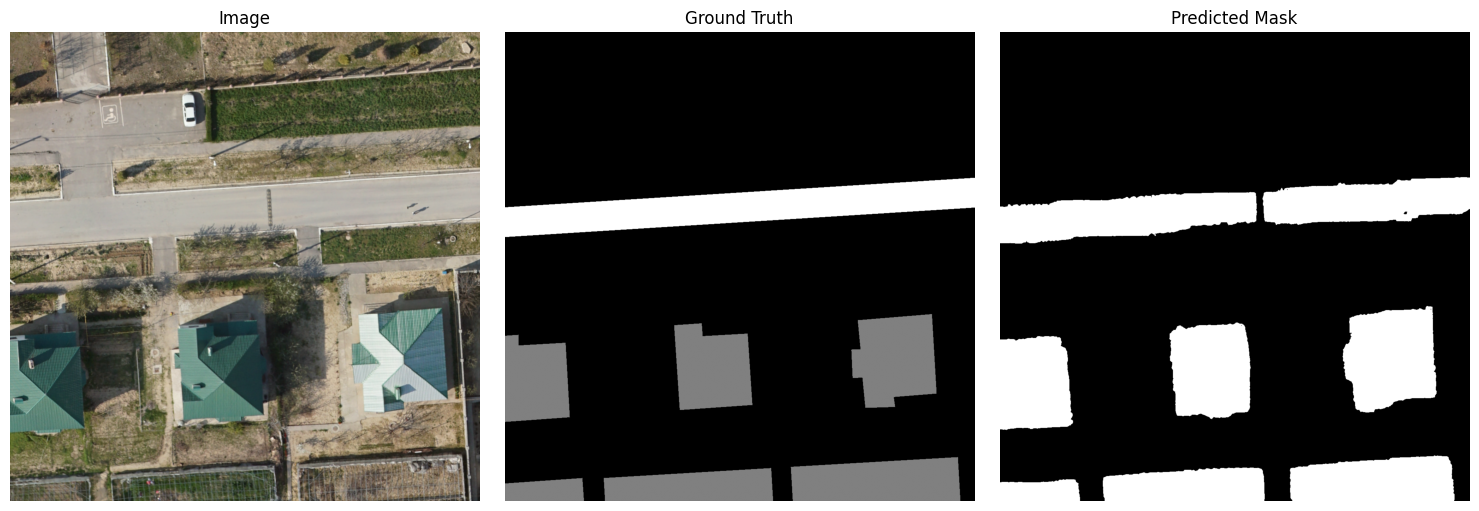

Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

✅ Evaluation finished on 1 samples
Mean IoU: 0.8273 | Precision: 0.8428 | Recall: 0.9782 | F1: 0.9055


In [40]:
from matplotlib import pyplot as plt


def evaluate_dataset(
    predictor,
    dataset,
    save_dir="predicted_labels",
    add_negatives=False,
    specific_entry=None,   # <-- New argument: single image dict {'image': ..., 'annotation': ...}
    plot_result=False      # <-- Whether to plot the image/masks
):
    os.makedirs(save_dir, exist_ok=True)

    ious, precisions, recalls, f1s = [], [], [], []

    if specific_entry is not None:
        entries = [specific_entry]
    else:
        entries = dataset

    for entry in tqdm(entries, desc="Evaluating"):
        image_path = entry['image']
        mask_path = entry['annotation']
        image, mask = read_image(image_path, mask_path)

        input_points, input_labels = sample_points_from_mask(mask, add_negatives=add_negatives)
        if input_points is None:
            continue

        with torch.no_grad():
            predictor.set_image(image)
            masks, scores, logits = predictor.predict(
                point_coords=input_points,
                point_labels=input_labels,
                multimask_output=True
            )

        # Postprocess to original resolution
            masks = predictor._transforms.postprocess_masks(
                torch.as_tensor(masks, device="cuda"),
                predictor._orig_hw[-1]
            ).cpu().numpy()    

        # Combine all predicted masks into one binary mask
        prd_masks = np.array(masks[:, 0])
        pred_mask = (prd_masks.max(axis=0) > 0).astype(np.uint8)

        # Compute metrics
        iou, precision, recall, f1 = compute_metrics(mask, pred_mask)
        ious.append(iou)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        # Save predicted mask
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        save_path = os.path.join(save_dir, f"{base_name}_pred.png")
        cv2.imwrite(save_path, pred_mask.astype(np.uint8) * 255)

        # Optionally plot
        if plot_result:
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.title("Image")
            plt.imshow(image)
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.title("Ground Truth")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    mean_iou = np.mean(ious) if ious else 0.0
    mean_precision = np.mean(precisions) if precisions else 0.0
    mean_recall = np.mean(recalls) if recalls else 0.0
    mean_f1 = np.mean(f1s) if f1s else 0.0

    print(f"✅ Evaluation finished on {len(ious)} samples")
    print(f"Mean IoU: {mean_iou:.4f} | Precision: {mean_precision:.4f} | Recall: {mean_recall:.4f} | F1: {mean_f1:.4f}")

    return mean_iou, mean_precision, mean_recall, mean_f1

# -----------------------------
# Run evaluation
# -----------------------------
FINE_TUNED_MODEL_WEIGHTS = r"/ediss_data/ediss4/sarosh/mira/Thesis/segment-anything-2/fine_tuned_sam2_best-check2.pth"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

specific_entry = {
    "image": r"/ediss_data/ediss4/sarosh/mira/Thesis/yolo_images_Shymkent/Shymkent_5cm_10_26_tile_11_12.png",
    "annotation": PROJECT_DIR + "/sam_dataset_new/masks/combined/train/Shymkent_5cm_10_26_tile_11_12_combined.png"
}

mean_iou, mean_precision, mean_recall, mean_f1 = evaluate_dataset(
    predictor,
    dataset=None,  # ignored if specific_entry is set
    save_dir="predicted_labels_single",
    add_negatives=False,
    specific_entry=specific_entry,
    plot_result=True
)

In [41]:
def sample_points_from_mask_with_class(mask, add_negatives=False):
    class_vals = [c for c in np.unique(mask) if c != 0]
    points, labels, point_class_ids = [], [], []
    kernel = np.ones((3,3), np.uint8)

    for c in class_vals:
        comp_n, comp = cv2.connectedComponents((mask == c).astype(np.uint8))
        for lid in range(1, comp_n):
            inst = (comp == lid).astype(np.uint8)
            if inst.sum() == 0:
                continue
            eroded = cv2.erode(inst, kernel, iterations=1)
            if eroded.sum() == 0:
                eroded = inst
            coords = np.argwhere(eroded>0)
            if len(coords) == 0:
                continue
            y, x = coords[np.random.randint(len(coords))]
            points.append([x,y])
            labels.append(1)
            point_class_ids.append(c)  # <-- keep track of class

    if len(points) == 0:
        return None, None, None

    points = np.array(points)[:,None,:]
    labels = np.array(labels)[:,None]
    point_class_ids = np.array(point_class_ids)

    if add_negatives:
        # add background points if needed
        pass

    return points, labels, point_class_ids


In [42]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from shapely.geometry import Polygon

def mask_to_polygons(mask, class_id):
    """Return polygons for a specific class in a multi-class mask"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [Polygon(cnt.squeeze()) for cnt in contours if cnt.shape[0] > 2]
    return polygons

def mask_to_aabbs(mask, class_id):
    """Return axis-aligned bounding boxes for a specific class"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(cnt) for cnt in contours]  # (x, y, w, h)
    return boxes

def mask_to_rotated_boxes(mask, class_id):
    """Return rotated bounding boxes for a specific class"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rotated_boxes = [cv2.boxPoints(cv2.minAreaRect(cnt)).astype(int) for cnt in contours]
    return rotated_boxes

def visualize_multiclass_outputs(img, mask, class_colors=None, show_polygons=True, show_aabb=False, show_rotated=False):
    """
    Visualize multi-class mask outputs: polygons, AABB, rotated boxes.
    """
    img_vis = img.copy()
    if class_colors is None:
        class_ids = np.unique(mask)
        class_colors = {cls: tuple(np.random.randint(0,256,3).tolist()) for cls in class_ids if cls != 0}

    for cls, color in class_colors.items():
        if show_polygons:
            polygons = mask_to_polygons(mask, cls)
            for poly in polygons:
                pts = np.array(poly.exterior.coords, np.int32)
                cv2.polylines(img_vis, [pts], isClosed=True, color=color, thickness=2)

        if show_aabb:
            boxes = mask_to_aabbs(mask, cls)
            for x, y, w, h in boxes:
                cv2.rectangle(img_vis, (x, y), (x+w, y+h), color, 2)

        if show_rotated:
            boxes = mask_to_rotated_boxes(mask, cls)
            for pts in boxes:
                cv2.polylines(img_vis, [pts], isClosed=True, color=color, thickness=2)

    plt.figure(figsize=(6,6))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.show()


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Class 1: IoU 0.7294, F1 0.8435, Precision 0.8472, Recall 0.8399
Class 2: IoU 0.8132, F1 0.8970, Precision 0.8221, Recall 0.9869


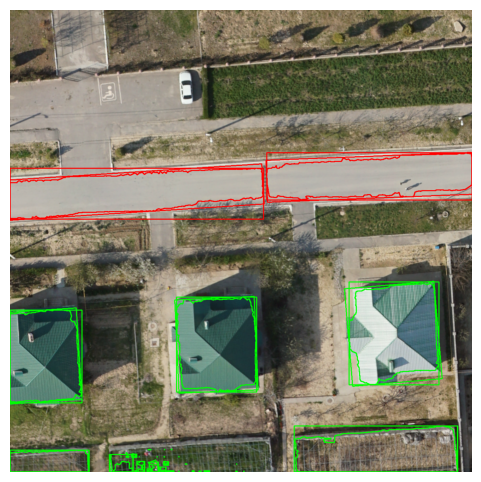

Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

✅ Evaluation finished


In [43]:
def evaluate_dataset_multiclass(
    predictor,
    dataset,
    save_dir="predicted_labels",
    add_negatives=False,
    specific_entry=None,
    plot_result=False
):
    os.makedirs(save_dir, exist_ok=True)
    class_ids_for_points = []  # store class IDs for each prompt point
    
    if specific_entry is not None:
        entries = [specific_entry]
    else:
        entries = dataset

    for entry in tqdm(entries, desc="Evaluating"):
        image_path = entry['image']
        mask_path = entry['annotation']
        image, mask = read_image(image_path, mask_path)

        # Sample points and also get class IDs per point
        points, labels, point_class_ids = sample_points_from_mask_with_class(mask)
        if points is None:
            continue

        with torch.no_grad():
            predictor.set_image(image)
            masks, scores, logits = predictor.predict(
                point_coords=points,
                point_labels=labels,
                multimask_output=True
            )

            # Postprocess to original resolution
            masks = predictor._transforms.postprocess_masks(
                torch.as_tensor(masks, device="cuda"),
                predictor._orig_hw[-1]
            ).cpu().numpy()

        # Convert instance masks to multi-class mask
        multi_class_mask = np.zeros_like(mask, dtype=np.uint8)
        for idx, cls in enumerate(point_class_ids):
            inst_mask = masks[idx,0] > 0
            multi_class_mask[inst_mask] = cls

        # Compute metrics (optional, per-class)
        for cls in [1,2]:  # your class IDs
            gt_cls = (mask == cls).astype(np.uint8)
            pred_cls = (multi_class_mask == cls).astype(np.uint8)
            iou, precision, recall, f1 = compute_metrics(gt_cls, pred_cls)
            print(f"Class {cls}: IoU {iou:.4f}, F1 {f1:.4f}, Precision {precision:.4f}, Recall {recall:.4f}")

        # Save predicted multi-class mask
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        save_path = os.path.join(save_dir, f"{base_name}_pred.png")
        cv2.imwrite(save_path, multi_class_mask.astype(np.uint8))

        # Plot result
        if plot_result:
            visualize_multiclass_outputs(image, multi_class_mask, class_colors={1:(0,255,0),2:(255,0,0)}, show_polygons=True, show_aabb=True, show_rotated=True)

    print("✅ Evaluation finished")

evaluate_dataset_multiclass(
    predictor,
    dataset=None,
    save_dir="predicted_labels_multiclass",
    add_negatives=False,
    specific_entry=specific_entry,
    plot_result=True
)
